## **Parte 1:** Importanción de librerías

Suprimiendo los Warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

Importando las librerías necesarias

In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [3]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## **Parte 2:** Cargando los datos

In [4]:
df = pd.read_csv("../BD_procesada/BD_procesada.csv", sep=";")
df.head()

,muestra 1,muestra 2,muestra 3,muestra 4,muestra 5,muestra 6,muestra 7,muestra 8,muestra 9,muestra 10,...,muestra 2492,muestra 2493,muestra 2494,muestra 2495,muestra 2496,muestra 2497,muestra 2498,muestra 2499,muestra 2500,estructura
0,-54,-14,-102,-286,-384,-379,-358,-340,-244,-144,...,45,100,58,31,1,-25,15,0,-4,1
1,-142,-242,-218,-144,-150,-214,-145,33,226,315,...,61,-59,-125,-86,70,162,234,189,151,1
2,2,7,15,27,47,45,-9,-75,-94,-71,...,-108,-81,-86,-27,-24,-11,-2,47,38,0
3,135,-96,-6,-100,10,-68,-138,-335,-373,-199,...,116,111,279,282,333,138,-17,-14,-200,0
4,-68,-91,67,119,83,128,-55,22,-139,-69,...,-18,17,157,255,322,467,188,298,199,0


## **Parte 3:** transformando los datos

Diviendo el conjunto en entranimiento y prueba

In [5]:
X = df.drop(columns=['estructura'], axis=1)
y = df['estructura']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Estandarizar los datos

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Reshape de los datos para que tengan la forma adecuada para la convolución (número de registros, longitud de los registros, número de características)

In [7]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

## **Parte 4:** Modelo

Creación de la estructura del modelo

In [8]:
def estructura_modelo(x_train_) -> Sequential:
    modelo_ = Sequential()

    modelo_.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train_.shape[1], 1)))
    modelo_.add(MaxPool1D(pool_size=2))

    modelo_.add(Flatten())

    modelo_.add(Dense(128, activation='relu'))
    modelo_.add(Dropout(0.5))

    modelo_.add(Dense(1, activation='sigmoid'))

    return modelo_

In [9]:
modelo = estructura_modelo(x_train_=X_train_reshaped)

Compilación del modelo

In [10]:
modelo.compile(optimizer=Adam(), loss = 'binary_crossentropy')

Entrenando el modelo

In [11]:
modelo.fit(X_train_reshaped, y_train, epochs=40, batch_size=64, validation_split=0.1)

Epoch 1/40
45/45 [==============================] - 2s 9ms/step - loss: 0.9733 - val_loss: 0.6852
Epoch 2/40
45/45 [==============================] - 0s 6ms/step - loss: 0.6716 - val_loss: 0.6711
Epoch 3/40
45/45 [==============================] - 0s 5ms/step - loss: 0.6582 - val_loss: 0.6560
Epoch 4/40
45/45 [==============================] - 0s 6ms/step - loss: 0.6234 - val_loss: 0.6491
Epoch 5/40
45/45 [==============================] - 0s 6ms/step - loss: 0.5835 - val_loss: 0.6096
Epoch 6/40
45/45 [==============================] - 0s 5ms/step - loss: 0.5334 - val_loss: 0.5820
Epoch 7/40
45/45 [==============================] - 0s 6ms/step - loss: 0.4957 - val_loss: 0.5705
Epoch 8/40
45/45 [==============================] - 0s 6ms/step - loss: 0.4852 - val_loss: 0.5353
Epoch 9/40
45/45 [==============================] - 0s 6ms/step - loss: 0.4361 - val_loss: 0.5702
Epoch 10/40
45/45 [==============================] - 0s 7ms/step - loss: 0.4162 - val_loss: 0.5559
Epoch 11/40
45/45 [

Evaluación del modelo

25/25 [==============================] - 0s 440us/step

Matriz de Confusión:


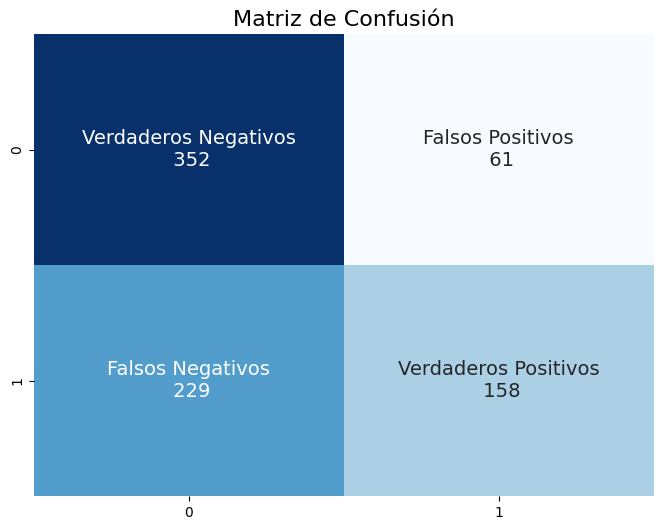

Accuracy:	63.75%
Sensitivity:	40.83%
Specificity:	85.23%
Precision:	72.15%
F1-score:	52.15%


In [12]:
y_pred_prob = modelo.predict(X_test_reshaped)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.85).astype(int)

#Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))

Validación cruzada

In [13]:
#Se define el número de pliegues para la validación cruzada
n_folds = 10

#Inicializar las listas para almacenar las métricas de evaluación en cada pliegue
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
specificity_scores = []

#Inicializar StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

#Matriz de confusión para validación cruzada
conf_matriz_2 = None

#Iterar sobre cada pliegue
for train_index, test_index in skf.split(X=X, y=y):
    X_train_fold, X_test_fold = X.values[train_index], X.values[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    #Estandarizar los datos
    scaler_ = StandardScaler()
    X_train_fold_scaled = scaler_.fit_transform(X_train_fold)
    X_test_fold_scaled = scaler_.transform(X_test_fold)

    #Cambiar de forma para que tengan la forma adecuada para la convolución
    X_train_fold_reshaped = X_train_fold_scaled.reshape(X_train_fold_scaled.shape[0], X_train_fold_scaled.shape[1], 1)
    X_test_fold_reshaped = X_test_fold_scaled.reshape(X_test_fold_scaled.shape[0], X_test_fold_scaled.shape[1], 1)

    #Entrenar el modelo con el pliegue actual
    modelo = estructura_modelo(x_train_=X_train_fold_reshaped)
    modelo.compile(optimizer=Adam(), loss = 'binary_crossentropy')
    modelo.fit(X_train_fold_reshaped, y_train_fold, epochs=40, batch_size=64, validation_split=0.1, verbose=0)

    # Evaluar el modelo en el pliegue actual
    y_pred_fold = modelo.predict(X_test_fold_reshaped)
    #Convertir las probabilidades en clases binarias usando un umbral de 0.5
    y_pred_fold = (y_pred_fold > 0.5).astype(int)  

    #Métricas de desempeño
    conf_matriz_2 = confusion_matrix(y_test_fold, y_pred_fold)
    tn, fp, fn, tp = conf_matriz_2.ravel()
    specificity_scores.append(tn/(tn+fp))
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
    precision_scores.append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='weighted'))

13/13 [==============================] - 0s 1ms/step


KeyboardInterrupt: 


Matriz de Confusión:


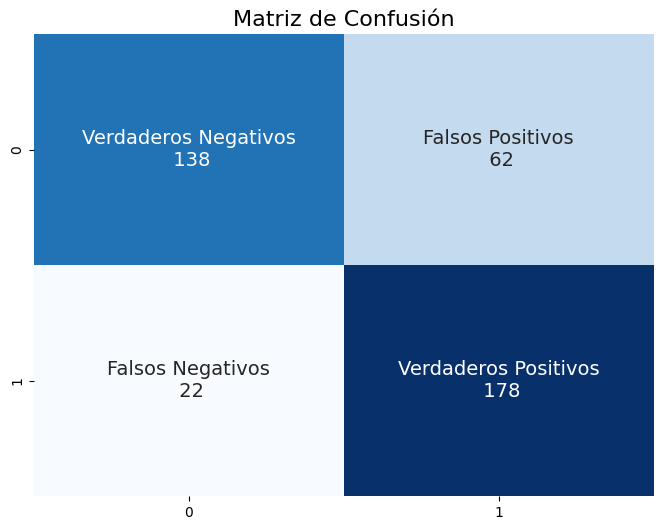


mean Accuracy:		0.73		std:	0.05
mean Sensitivity:	0.73		std:	0.05
mean Precision:		0.74		std:	0.06
mean F1-score:		0.73		std:	0.05
mean Specificity:	0.71		std:	0.07


In [ ]:
#Matriz de confusión
# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matriz_2)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matriz_2, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

#Calcular los promedios de las métricas
mean_accuracy       = np.mean(accuracy_scores)
mean_recall         = np.mean(recall_scores)
mean_specificity    = np.mean(specificity_scores)
mean_precision      = np.mean(precision_scores)
mean_f1             = np.mean(f1_scores)

#Calcular las desviaciones estandar
std_accuracy    = np.std(accuracy_scores)
std_recall      = np.std(recall_scores)
std_specificity = np.std(specificity_scores)
std_precision   = np.std(precision_scores)
std_f1          = np.std(f1_scores)

# Imprimir los resultados
print("\nmean Accuracy:\t\t{:.2f}\t\tstd:\t{:.2f}".format(mean_accuracy, std_accuracy))
print("mean Sensitivity:\t{:.2f}\t\tstd:\t{:.2f}".format(mean_recall, std_recall))
print("mean Precision:\t\t{:.2f}\t\tstd:\t{:.2f}".format(mean_precision, std_precision))
print("mean F1-score:\t\t{:.2f}\t\tstd:\t{:.2f}".format(mean_f1, std_f1))
print("mean Specificity:\t{:.2f}\t\tstd:\t{:.2f}".format(mean_specificity, std_specificity))

## **Parte 5:** Guardar el modelo

Se guarda el modelo con su puntaje de sensibilidad

In [ ]:
modelo.save(filepath="modelos/modelo_sensibilidad_{:.2f}.h5".format(mean_recall))